In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import argrelextrema

In [3]:
omp = 1
mpi = 4

Routines for the calculation of theta

In [4]:
def eval_pulse_area(ndb,field_int,width,kpoint=0,bands=[0,1],component=0):
    """
    Compute the coupling frequency and the pulse are in function of the
    field intensity
    
    Args:
        ndb : name of the dipoles database
        field_int : field intensity in kW/cm^2
        width : the width of the field in fs
        kpoint : selected kpoint
        bands : bands of the transition
        component : cartesian component of the dipole
    """
    Z0 = U.vacuum_impedence
    dipoles = U.get_variable_from_db(ndb,'DIP_iR')
    dip = dipoles[kpoint][bands[0]][bands[1]][component]
    dip_mod = np.sqrt(dip[0]**2+dip[1]**2)
    print('dipoles module :',dip_mod)

    field_int = field_int*1e3*1e4 #W/m^2
    field_amp = np.sqrt(Z0*field_int) #V/m
    field_amp = field_amp*U.Bohr_radius #V/a0 in atomic units
    coupling_frequency = dip_mod*field_amp*2*np.pi/U.Planck_ev_ps #THz
    
    theta = np.sqrt(2*np.pi)*width*coupling_frequency*1e-3
    print('coupling frequency (THz):',coupling_frequency)
    print('pulse area :',theta)
    return coupling_frequency,theta
    
def eval_field_intensity(ndb,theta,width,kpoint=0,bands=[0,1],component=0):
    """
    Compute the field intensity that produce the pulse are given as input
    
    Args:
        ndb : name of the dipoles database
        theta : pulse area
        width : the width of the field in fs
        kpoint : selected kpoint
        bands : bands of the transition
        component : cartesian component of the dipole
    """
    Z0 = U.vacuum_impedence
    dipoles = U.get_variable_from_db(ndb,'DIP_iR')
    dip = dipoles[kpoint][bands[0]][bands[1]][component]
    dip_mod = np.sqrt(dip[0]**2+dip[1]**2)
    print('dipoles module :',dip_mod)
    
    coupling_frequency = theta/(np.sqrt(2*np.pi)*width*1e-3) #THz
    field_amp = coupling_frequency/(dip_mod*2*np.pi/U.Planck_ev_ps) #V/a0 in atomic units
    field_amp = field_amp/U.Bohr_radius #V/m
    field_int = field_amp**2/Z0 #W/m^2
    field_int = field_int*1e-3*1e-4 #kW/cm^2
    print('field intensity (kW/cm^2) :',field_int)
    return field_int

In [5]:
def eval_pulse_area(ndb,field_int,width,kpoint=0,transitions=[[0,1]],component=0):
    """
    Compute the coupling frequency and the pulse are in function of the
    field intensity
    
    Args:
        ndb : name of the dipoles database
        field_int : field intensity in kW/cm^2
        width : the width of the field in fs
        kpoint : selected kpoint
        bands : all the transitions activated by the pump
        component : cartesian component of the dipole
    """
    Z0 = U.vacuum_impedence
    dipoles = U.get_variable_from_db(ndb,'DIP_iR')
    dip_mod = 0.
    for t in transitions:
        dip = dipoles[kpoint][t[0]][t[1]][component]
        dip_mod += np.sqrt(dip[0]**2+dip[1]**2)

    field_int = field_int*1e3*1e4 #W/m^2
    field_amp = np.sqrt(Z0*field_int) #V/m
    field_amp = field_amp*U.Bohr_radius #V/a0 in atomic units
    coupling_frequency = dip_mod*field_amp*2*np.pi/U.Planck_ev_ps #THz
    
    theta = np.sqrt(2*np.pi)*width*coupling_frequency*1e-3
    print('coupling frequency (THz):',coupling_frequency)
    print('pulse area :',theta)
    return coupling_frequency,theta
    
def eval_field_intensity(ndb,theta,width,kpoint=0,transitions=[[0,1]],component=0):
    """
    Compute the field intensity that produce the pulse are given as input
    
    Args:
        ndb : name of the dipoles database
        theta : pulse area
        width : the width of the field in fs
        kpoint : selected kpoint
        bands : bands of the transition
        component : cartesian component of the dipole
    """
    Z0 = U.vacuum_impedence
    dipoles = U.get_variable_from_db(ndb,'DIP_iR')
    dip_mod = 0.
    for t in transitions:
        dip = dipoles[kpoint][t[0]][t[1]][component]
        dip_mod += np.sqrt(dip[0]**2+dip[1]**2)
    
    coupling_frequency = theta/(np.sqrt(2*np.pi)*width*1e-3) #THz
    field_amp = coupling_frequency/(dip_mod*2*np.pi/U.Planck_ev_ps) #V/a0 in atomic units
    field_amp = field_amp/U.Bohr_radius #V/m
    field_int = field_amp**2/Z0 #W/m^2
    field_int = field_int*1e-3*1e-4 #kW/cm^2
    print('field intensity (kW/cm^2) :',field_int)
    return field_int

# RT analysis of GaAs

This notebook contains the RT analysis of the photon echo mechanism for GaAs performed with Yambo.

## Analysis of a single transition

We study the behavior of a simulation in which there is a single $k$ point (using the nosym option).

We select a $k$-point with valence conduction gap of 1.5 eV, for this point the three conduction bands
are not degenerate and thus we can isolate the 4,5 transition. This situation should be described by
the physics of a standard TLS (with the only difference provided by the spin degeneration that brings
a factor 2 in the number of carriers)

In [12]:
simulations = {
    'k1_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_st_pi_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 95033,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_st_pi2_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_st_hi_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 2e5,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
}

### Construction of the SAVE folder and FixSymm procedure

In [13]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(84769.0117036297run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE for k1_nosym sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_st_pi_nosym sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_st_pi2_nosym sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_st_hi_nosym sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [14]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 #fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as84769.0117036297

In [15]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [16]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_hi_nosym','k1_st_pi2_nosym']) #k1_singletrans']) 

In [17]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') == [4,5]:
        idd['bands'] = 'single-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

Initialize a parallel Yambo calculator with scheduler direct
run the computation for k1_nosym
Skip the run of bands_single-trans-eta_1e-05-field_eng_1.5-field_int_1000.0-sim_time_500
Job completed

run the computation for k1_st_pi_nosym
Skip the run of bands_single-trans-eta_1e-05-field_eng_1.5-field_int_95033-sim_time_500
Job completed

run the computation for k1_st_pi2_nosym
Skip the run of bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23758-sim_time_500
Job completed

run the computation for k1_st_hi_nosym
Skip the run of bands_single-trans-eta_1e-05-field_eng_1.5-field_int_200000.0-sim_time_500
Job completed



In [18]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi_nosym','k1_st_pi2_nosym','k1_st_hi_nosym'])

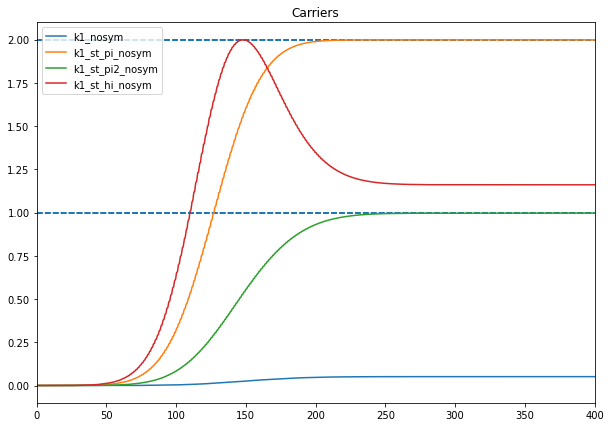

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    plt.hlines(1.,0,400,linestyles='--')
    plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

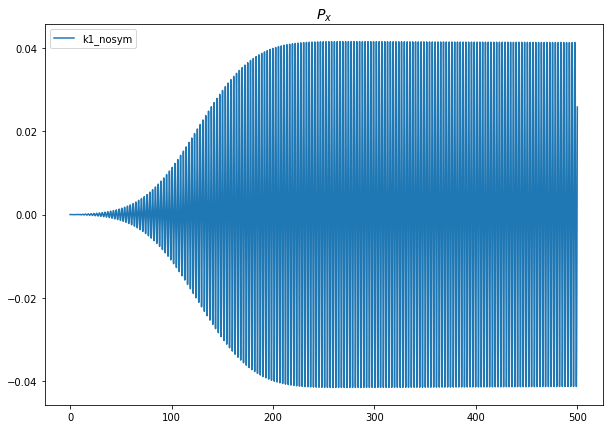

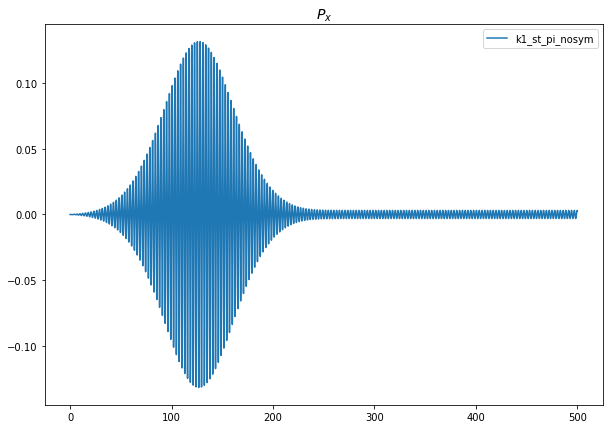

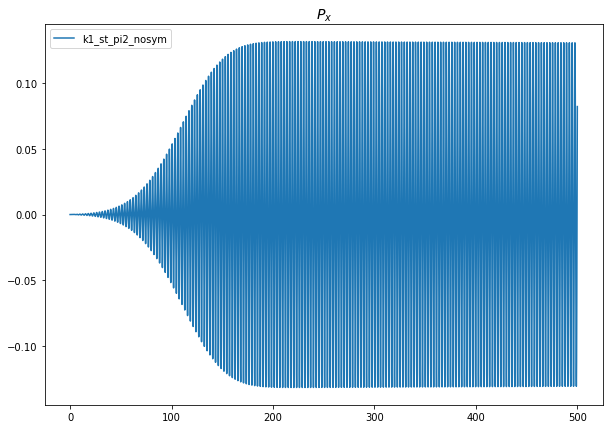

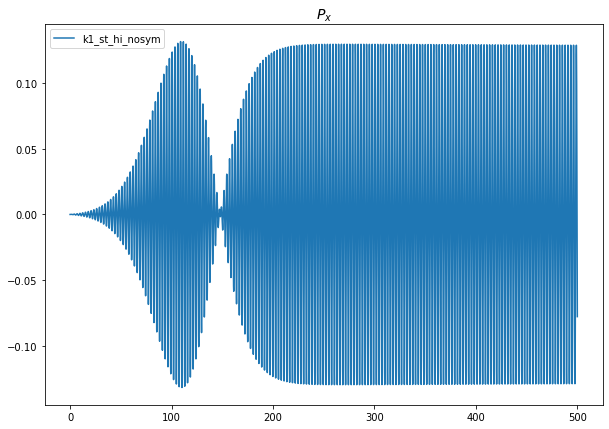

In [20]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

In [15]:
ndb_path = simulations['k1_nosym']['ndb']
width = 42.46609 # the field width in fs

In [16]:
field_int = 2e5
eval_pulse_area(os.path.join(ndb_path,'ndb.dipoles'),field_int,width)

coupling frequency (THz): 42.81496294022776
pulse area : 4.5575115972587374


(42.81496294022776, 4.5575115972587374)

In [17]:
theta = np.pi
eval_field_intensity(os.path.join(ndb_path,'ndb.dipoles'),theta,width)

field intensity (kW/cm^2) : 95032.94241967653


95032.94241967653

## Analysis of a single $k$-point (with multiple transitions)

We analyze the same simulations performed before removing the option that selects
only a single transition

In [39]:
simulations = {
    'k1_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    'k1_pi_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 95033,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    'k1_pi2_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    'k1_hi_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 2e5,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    'k1_pi2_nosym_extrans': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [2,6]
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [40]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE for k1_nosym sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_pi_nosym sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_pi2_nosym sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_hi_nosym sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_pi2_nosym_extrans sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/S

### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [41]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 # fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [42]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [50]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi2_nosym']) #k1_singletrans'])

In [44]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') == [2,6]:
        idd['bands'] = 'ext-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

Initialize a parallel Yambo calculator with scheduler direct
run the computation for k1_nosym
Skip the run of eta_1e-05-field_eng_1.5-field_int_1000.0-sim_time_500
Job completed

run the computation for k1_pi_nosym
Skip the run of eta_1e-05-field_eng_1.5-field_int_95033-sim_time_500
Job completed

run the computation for k1_pi2_nosym
Skip the run of eta_1e-05-field_eng_1.5-field_int_23758-sim_time_500
Job completed

run the computation for k1_hi_nosym
Skip the run of eta_1e-05-field_eng_1.5-field_int_200000.0-sim_time_500
Job completed

run the computation for k1_pi2_nosym_extrans
Skip the run of bands_ext-trans-eta_1e-05-field_eng_1.5-field_int_23758-sim_time_500
Job completed



In [48]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_pi2_nosym','k1_pi2_nosym_extrans'])

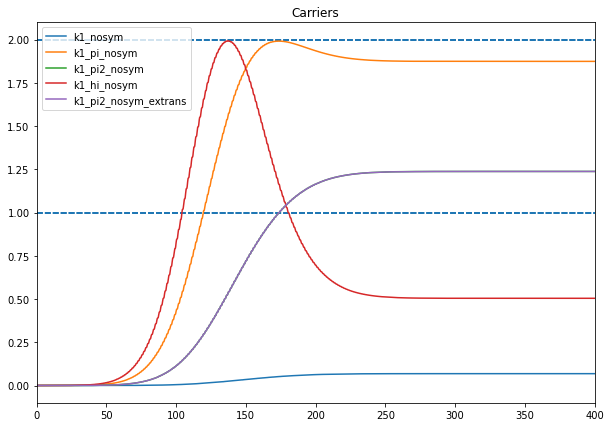

In [51]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    plt.hlines(1.,0,400,linestyles='--')
    plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

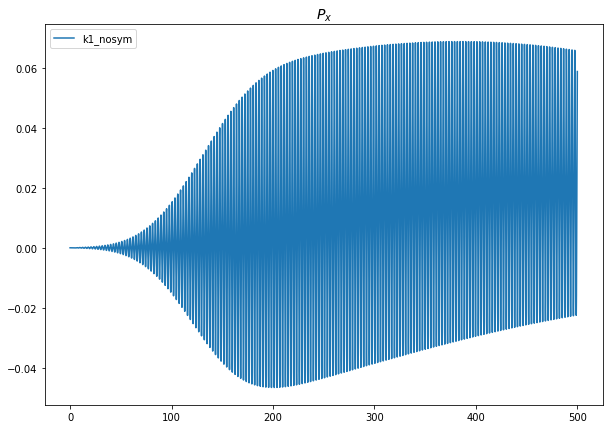

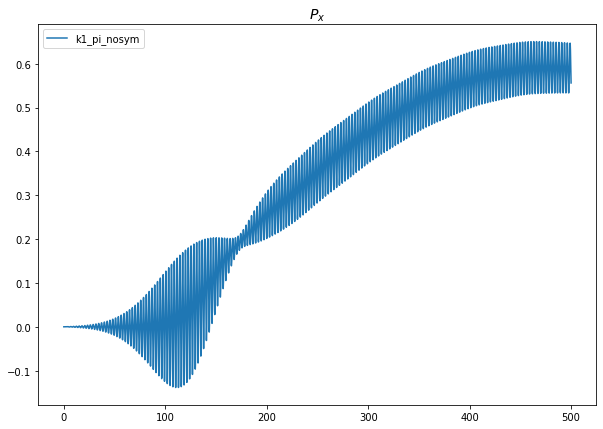

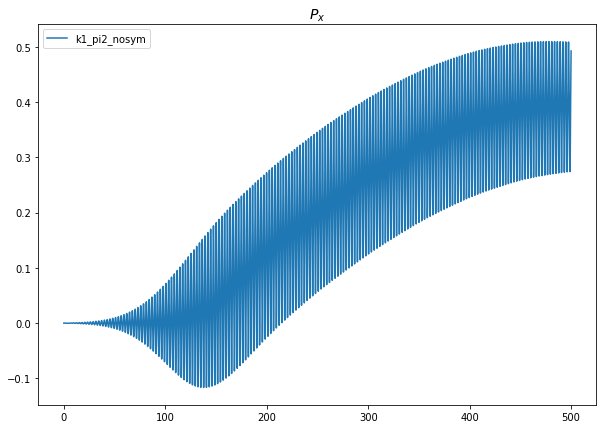

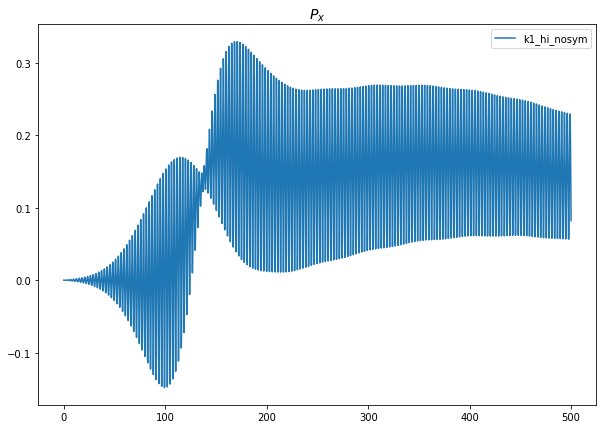

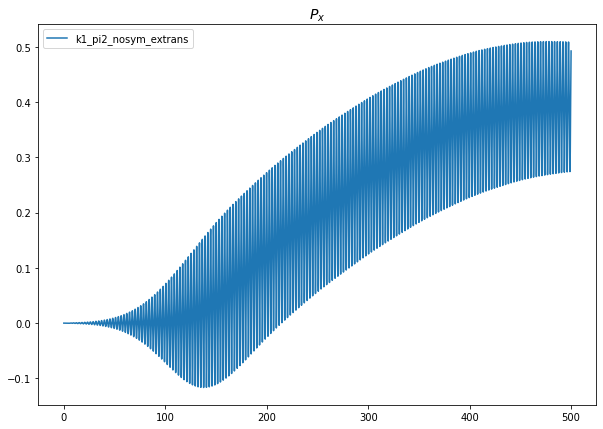

In [52]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

## Analysis at $\Gamma$ point

We perform the simulations at $\Gamma$ where the multiple transitions cannot be isolated due to the
degeneracy of the bands.

In [109]:
simulations = {
    'gamma': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_gamma', 
        'field_int' : 1e3,
        'field_eng' : 1.42,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'gamma_pi2': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_gamma',
        'field_int' : 2644.21,
        'field_eng' : 1.42,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'gamma_pi': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_gamma',
        'field_int' : 0,
        'field_eng' : 1.42,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [111]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for gamma
SAVE folder already present in RT_gamma. No operations performed.
FixSymm folder RT_gamma/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for gamma_pi2
SAVE folder already present in RT_gamma. No operations performed.
FixSymm folder RT_gamma/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for gamma_pi
SAVE folder already present in RT_gamma. No operations performed.
FixSymm folder RT_gamma/FixSymm already found. No operations performed.
 
mv RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [112]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 # fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [113]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [115]:
#sel_sim = simulations
sel_sim = dict((k,simulations[k]) for k in ['gamma','gamma_pi2'])

In [116]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') == [2,6]:
        idd['bands'] = 'ext-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

Initialize a parallel Yambo calculator with scheduler direct
run the computation for gamma
Skip the run of eta_1e-05-field_eng_1.42-field_int_1000.0-sim_time_500
Job completed

run the computation for gamma_pi2
run 0 command: cd RT_gamma/FixSymm; mpirun -np 4 yambo_rt -F eta_1e-05-field_eng_1.42-field_int_2644.21-sim_time_500.in -J eta_1e-05-field_eng_1.42-field_int_2644.21-sim_time_500 -C eta_1e-05-field_eng_1.42-field_int_2644.21-sim_time_500
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
Job completed



In [98]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_pi2_nosym','k1_pi2_nosym_extrans'])

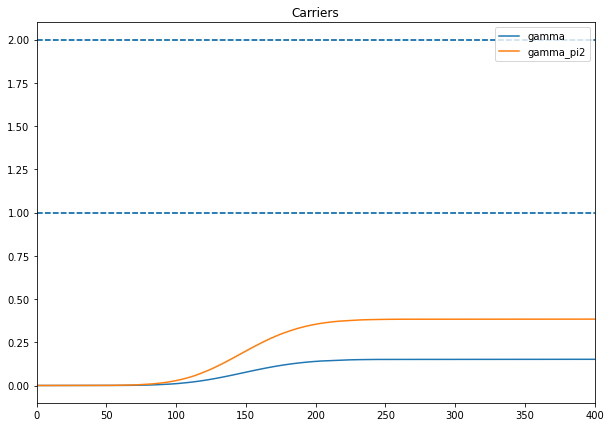

In [117]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    plt.hlines(1.,0,400,linestyles='--')
    plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

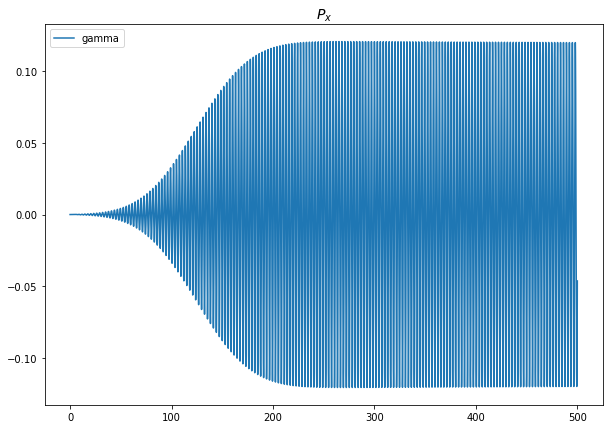

In [60]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

We use the routines to compute the field intensity that produce the $\pi/2$ or the $\pi$
condition

In [104]:
ndb_path = simulations['gamma']['ndb']
width = 42.46609 # the field width in fs

In [106]:
field_int = 95972.7
eval_pulse_area(os.path.join(ndb_path,'ndb.dipoles'),field_int,width,transitions=[[0,3],[1,3],[2,3]])

coupling frequency (THz): 88.90243941216283
pulse area : 9.463371466913829


(88.90243941216283, 9.463371466913829)

In [108]:
theta = 0.5*np.pi
eval_field_intensity(os.path.join(ndb_path,'ndb.dipoles'),theta,width,transitions=[[0,3],[1,3],[2,3]])

field intensity (kW/cm^2) : 2644.208465857056


2644.208465857056

we observe that the three valence bands contribute in a similar way

We see that the evaluation of $\Theta$ performed with the sum of the dipoles does not produce the expected
result, probably this is due to the fact that the various TLS are coupled by the single conduction band.

## Multi $k$ analysis - Single gaussian pulse

We build of the dictionary with the parameters of the various simulations.

In [32]:
simulations = {
    'k100': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 1000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    }    
}

### Construction of the SAVE folder and FixSymm procedure

In [33]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for k100
Create folder RT_k100_kspan0.04
Executing command: cd NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save; p2y -a 2
Create a symlink of /home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save/SAVE in RT_k100_kspan0.04
Executing command: cd RT_k100_kspan0.04;OMP_NUM_THREADS=1 yambo
Perform the fixSymm in the folder RT_k100_kspan0.04
Initialize a parallel Yambo calculator with scheduler direct
run 0 command: cd RT_k100_kspan0.04; mpirun -np 1 ypp -F FixSymm.in -J FixSymm -C FixSymm
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
Job completed
 
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [34]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 # fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [35]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [43]:
#simulations

In [44]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi2_nosym']) #k1_singletrans'])

In [ ]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') is not None:
        idd['bands'] = 'single-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

In [28]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi_nosym','k1_st_pi2_nosym','k1_st_hi_nosym'])

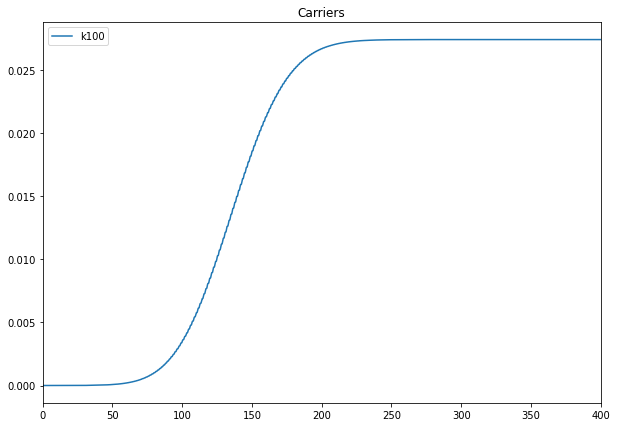

In [47]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    #plt.hlines(1.,0,400,linestyles='--')
    #plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

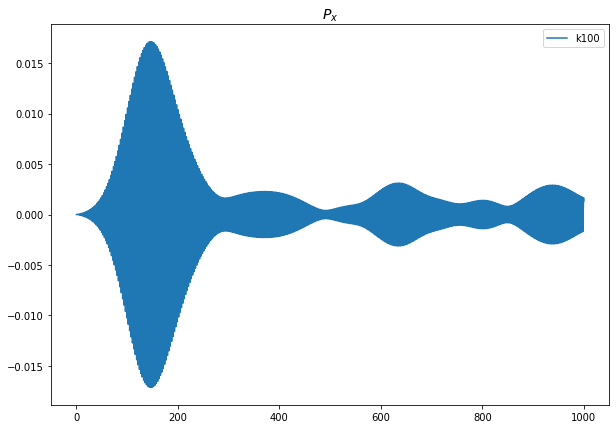

In [50]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

## Multi $k$ analysis - Double gaussian pulse for echo mechanism

We build of the dictionary with the parameters of the various simulations.

In [40]:
simulations = {
    'echo1': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04',
        'field_pol' : 'linear', # a common value since is used for the fixsymm
        'fields'  : {1 : {'int' : 1e3, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 90e3, 'eng' : 1.5, 'width' : 100, 'tstart' : 800}},
        'sim_time'  : 2000,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'echo2': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04',
        'field_pol' : 'linear', # a common value since is used for the fixsymm
        'fields'  : {1 : {'int' : 23758, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 90e3, 'eng' : 1.5, 'width' : 100, 'tstart' : 800}},
        'sim_time'  : 3000,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    }    
}

### Construction of the SAVE folder and FixSymm procedure

In [41]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for echo1
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for echo2
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [42]:
# Common parameters (eventually overwritten by the dictionary values)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [43]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=pars['rt_run_dir'])
    for ind,f in pars['fields'].items():
        rt_input.set_rt_field(index=ind,int=f['int'],width=f['width'],polarization=pars['field_pol'],freq=f['eng'],tstart=f['tstart'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [49]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi2_nosym'])

In [ ]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    #idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    #if pars.get('Gauge') is not None:
    #    idd['gauge'] = pars['Gauge']
    #if pars.get('bands') is not None:
    #    idd['bands'] = 'single-trans'
    #name = D.name_from_id(idd)
    name = sim
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

In [28]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi_nosym','k1_st_pi2_nosym','k1_st_hi_nosym'])

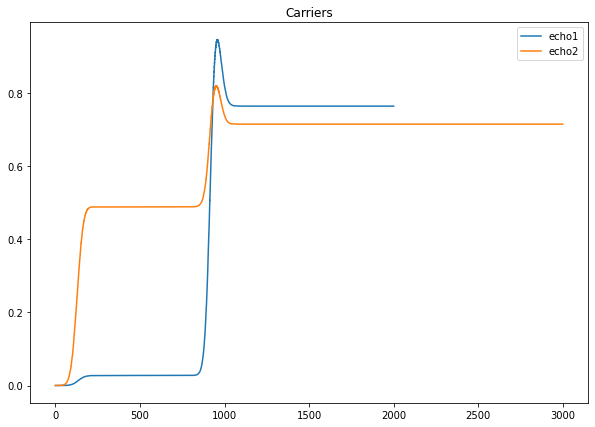

In [51]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    #plt.hlines(1.,0,400,linestyles='--')
    #plt.hlines(2,0,400,linestyles='--')
    #ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

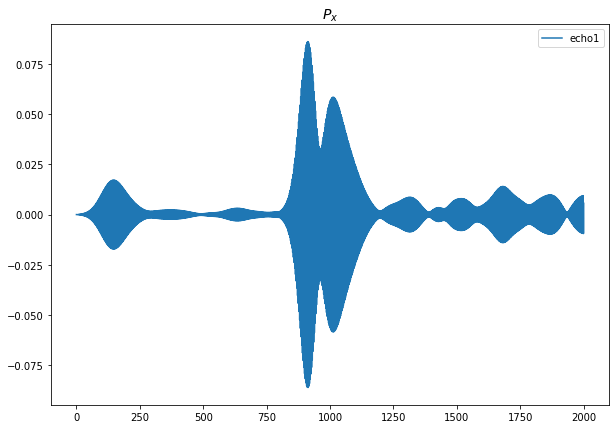

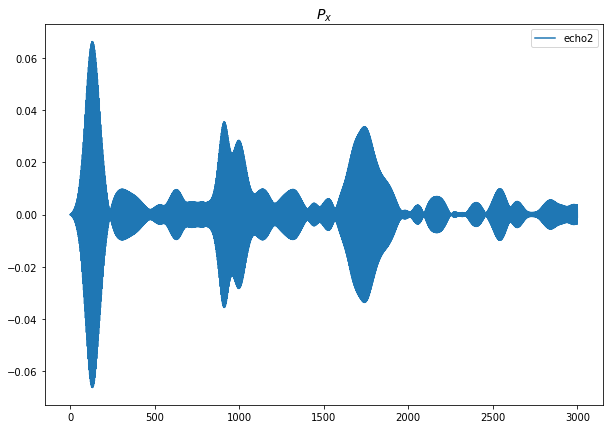

In [52]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()